In [1]:
# make sure you're logged in with \`huggingface-cli login\`
from diffusers import StableDiffusionParticlePipeline, LMSDiscreteScheduler, DDIMScheduler, DDPMScheduler, SDEScheduler, EulerDiscreteScheduler
import torch
import argparse
import os
from torchvision.utils import make_grid, save_image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

c:\Users\Yueze\anaconda3\envs\particle\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load SD-1.5

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

pipe = StableDiffusionParticlePipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("cuda")
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

unet\diffusion_pytorch_model.safetensors not found
c:\Users\Yueze\anaconda3\envs\particle\lib\site-packages\transformers\modeling_utils.py:429: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(checkpoint_file, framework="pt") as f:


Loading pipeline class <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_particle.StableDiffusionParticlePipeline'> from C:\Users\Yueze\.cache\huggingface\hub\models--runwayml--stable-diffusion-v1-5\snapshots\1d0c4ebf6ff58a5caecab40fa1406526bca4b5b9
config_dict {'_class_name': 'StableDiffusionPipeline', '_diffusers_version': '0.6.0', 'feature_extractor': ['transformers', 'CLIPImageProcessor'], 'safety_checker': ['stable_diffusion', 'StableDiffusionSafetyChecker'], 'scheduler': ['diffusers', 'PNDMScheduler'], 'text_encoder': ['transformers', 'CLIPTextModel'], 'tokenizer': ['transformers', 'CLIPTokenizer'], 'unet': ['diffusers', 'UNet2DConditionModel'], 'vae': ['diffusers', 'AutoencoderKL']}


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


# Define the prompt

In [3]:
prompt = ['VAN GOGH CAFE TERASSE copy.jpg']

In [4]:
seed = 6
num_of_image = 4
prompt = prompt * num_of_image
# number of sampling steps
steps = 30
# guidance scale
w = 8 


# Vanilla (i.i.d. sampling)

In [5]:
generator = torch.Generator(device="cuda").manual_seed(seed)

out = pipe(prompt, generator=generator, num_inference_steps=steps, guidance_scale=w, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()

d:\particle-guidance-main\stable_diffusion\diffusers\models\attention_processor.py:641: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(


# Particle Guidance (pixel)

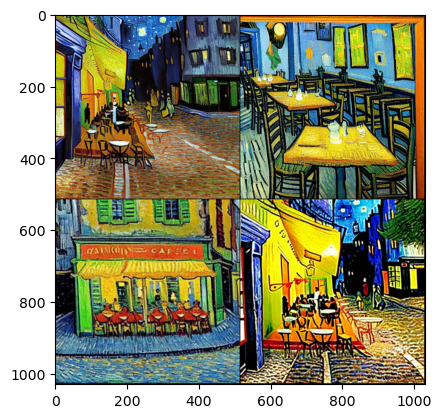

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff = 30
out = pipe(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()

# Particle Guidance (dino feature space)

In [ ]:
# load dino 
dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16').to("cuda")

Using cache found in /data/scratch/ylxu/.cache/torch/hub/facebookresearch_dino_main


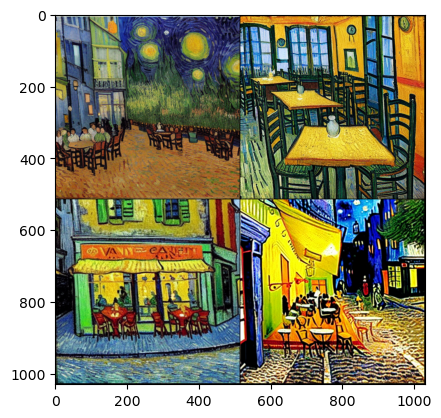

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seed)
# coefficient for the particle guidance scale
coeff = 8
out = pipe.dino(prompt, generator=generator, num_inference_steps=steps, coeff=coeff, guidance_scale=w, dino=dino, output_type='tensor')
image = out.images
image_grid = make_grid(torch.from_numpy(image).permute(0, 3, 1, 2), nrow=int(np.sqrt(len(image))))
plt.imshow(image_grid.permute(1, 2, 0))

del out
torch.cuda.empty_cache()